In [ ]:
import matplotlib.pyplot as plt      
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn   
import matplotlib.pyplot as plt    
from skimage.color import rgb2gray         
import cv2                                 
from tqdm import tqdm
from high_pass_filter import *
from crop_images import *
from keras.optimizers import RMSprop, Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Do modelu z 10 klasami
class_names = ['Agfa_DC_504', 'Agfa_DC_733s', 'Agfa_DC_830i', 'Agfa_Sensor_505x', 'Agfa_Sensor_530s',
               'Canon_Ixsus_55', 'Canon_Ixsus_70', 'Canon_Powershot_A640', 'Casio_Ex_Z150', 'Pentax_Optio_W60']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

In [ ]:
#Do modelu z połącznym dc 504 i sensor 530s klasami
class_names = ['Agfa_DC_733s', 'Agfa_DC_830i', 'Agfa_Sensor_505x', 'Agfa_Sensor_530s_DC_504',
               'Canon_Ixsus_55', 'Canon_Ixsus_70', 'Canon_Powershot_A640', 'Casio_Ex_Z150', 'Pentax_Optio_W60']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

In [ ]:
#Do modelu binarnego
class_names = ['Agfa_DC_504',  'Agfa_Sensor_530s']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

In [ ]:
def load_data():
    
    datasets = ['/content/drive/My Drive/Photos/train', '/content/drive/My Drive/Photos/test']
    #datasets = ['/content/drive/My Drive/Data_binary/train', '/content/drive/My Drive/Data_binary/test']
    output = []
    
    for dataset in datasets: # wczytaj z folderu train i test
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # wczytaj pliki z folderów odpowiadającyh poszczególnym klasom
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # wczytaj poszczególne obrazy z folderu
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
              # pobieranie ścieżki dostępu do pliku z obrazkiem
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # wczytanie i dopasowanie wielkości
                image = cv2.imread(img_path) 
                image = cv2.resize(image, (768,768))
                b,g,r = cv2.split (image)
                b = high_pass_filter(b)
                g = high_pass_filter(g)
                r = high_pass_filter(r)
                image = cv2.merge((b,g,r))
                image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
                
                crop_images = crop_image(image)
               
                # dodawanie obrazu i etykiety do zbioru wyjściowego
               
                for i in range(len(crop_images)):
                  images.append(crop_images[i])
                  labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

  0%|          | 0/183 [00:00<?, ?it/s]

Loading /content/drive/My Drive/Photos/train


  0%|          | 0/98 [00:00<?, ?it/s]

Loading /content/drive/My Drive/Photos/test


100%|██████████| 184/184 [04:34<00:00,  1.49s/it]


In [ ]:
n_train = train_labels.shape[0] 
n_test = test_labels.shape[0] 

print ("Number of training images: {}".format(n_train))
print ("Number of testing images: {}".format(n_test))
print ("Each image size is: {}".format(train_images[1].shape))

Number of training images: 17217
Number of testing images: 8226
Each image size is: (256, 256, 3)


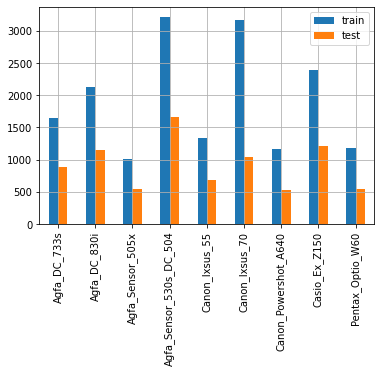

In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
df=pd.DataFrame({'train': train_counts,'test': test_counts}, index=class_names)
df.plot.bar()
plt.grid('on')
plt.show()

In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [ ]:
# ALEX NET

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
np.random.seed(1000)
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=256, input_shape=(256, 256 ,3), kernel_size=(3,3),  padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))

model.add(Conv2D(filters=128, kernel_size=(3,3),  padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
# 2nd Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3,3),  padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3,3),  padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3,3),  padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
#model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
#model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2),  padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(256, input_shape=(256*256*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.2))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.2))

# 3rd Fully Connected Layer
#model.add(Dense(1000))
#model.add(Activation('relu'))
# Add Dropout
#model.add(Dropout(0.4))

# Output Layer
model.add(Dense(100))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 256)     7168      
_________________________________________________________________
activation (Activation)      (None, 254, 254, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     295040    
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        7

In [ ]:
# MOJA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten


model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(64 , kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(32 , kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(3,3)))






model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(4096, activation='softmax')) 


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 84, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 82, 82, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 32)          9

In [ ]:
CLASS_NUM = 10
BATCH_SIZE = 32
EPOCH_STEPS = int(4323/BATCH_SIZE)
IMAGE_SHAPE = (256, 256, 3)

In [ ]:
!ls 'drive/My Drive/model82/saved_model.pb'

'drive/My Drive/model82/saved_model.pb'


In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('drive/My Drive/model90/')

# Check its architecture
new_model.summary()


# Evaluate the restored model
#loss, acc = new_model.evaluate(test_images,  test_labels, verbose=2)
#print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

#print(new_model.predict(test_images).shape)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         max_pooling2d[0][0]              
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer)
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer)
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax')(layer)
    
    model = Model(inputs=layer_in, outputs=[main])
    
    return model


# train model
model = googlenet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         max_pooling2d[0][0]              
_______________________________________________________________________________________

In [ ]:
np.random.seed(10)

model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss=keras.losses.categorical_crossentropy, optimizer=’adam’, metrics=[“accuracy”])
history = model.fit(train_images, train_labels, batch_size=32, epochs=100, validation_data=(test_images, test_labels))


539/539 [==============================] - 36s 67ms/step - loss: 0.1344 - accuracy: 0.9606 - val_loss: 0.3649 - val_accuracy: 0.9089


In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model_90') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model_90/assets


In [ ]:
cp -r 'saved_model/my_model_90' 'drive/My Drive/model90'

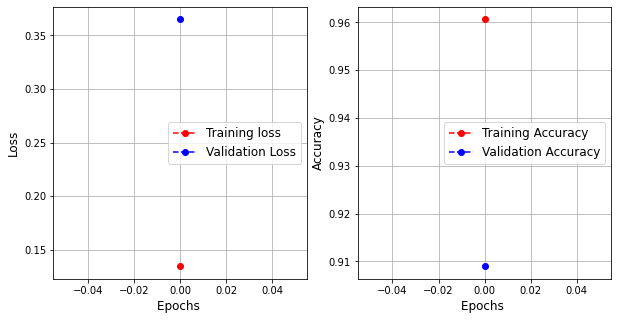

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history['loss'],'ro--')
plt.plot(history.history['val_loss'],'bo--')
plt.grid('on')
plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
 
plt.subplot(122)
plt.plot(history.history['accuracy'],'ro--')
plt.plot(history.history['val_accuracy'],'bo--')
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.grid('on')
plt.show()

In [ ]:
scores = model.evaluate(test_images, test_labels, verbose=0)
print('Accuracy (test): ', scores[1])
print('Loss (test): ', scores[0])

Accuracy (test):  0.908947229385376
Loss (test):  0.3649274706840515


In [ ]:
pred_labels=model.predict(test_images) # pred_labels w noracji one-hot
pred_labels = np.argmax(pred_labels, axis=-1) # etykieta to numer klasy

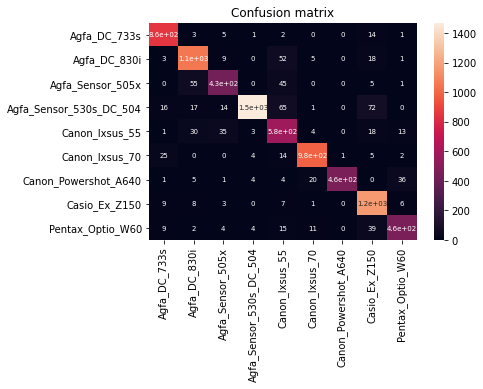

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 7}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()